In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

IMG_WIDTH, IMG_HEIGHT = 224, 224

import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import (
    DenseNet121,
    preprocess_input,
)
import pandas as pd
import numpy as np
import os
import IPython.display as display
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Conv2D,
    Flatten,
    GlobalMaxPooling2D,
    Dropout,
    Activation,
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from datetime import datetime
from packaging import version
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import efficientnet.tfkeras as enet





def append_extension(fn):
    return (fn + ".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[: class_number - 2] = 1
    return target


DATADIR = r"./adult"
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(CSV_PATH, sheet_name=0,)[["GreenID", "Grade"]].dropna(
    axis=0, subset=["Grade"]
)
response.Grade = response.Grade.astype("int")
response.GreenID = response.GreenID.astype("str").apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat(
    [response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T,],
    axis=1,
)


# shuffle dataset
response = response.sample(frac=1)
seed = np.random.randint(30027)


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def soft_acc_multi_output(y_true, y_pred):
    return K.mean(
        K.all(
            K.equal(
                K.cast(K.round(y_true), "int32"), K.cast(K.round(y_pred), "int32"),
            ),
            axis=1,
        )
    )


from tensorflow.keras import mixed_precision

# policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
# mixed_precision.experimental.set_policy(policy)

# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices("GPU")
#         print(
#             len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs",
#         )
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [2]:
data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    #     vertical_flip=True,
    validation_split=0.1,
    rescale=1.0 / 255.0,
    #     preprocessing_function = preprocess_input
    zoom_range=0.1,
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=True,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=28,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [3]:
base_model = DenseNet121(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.8)(x)
preds = Dense(4, activation="sigmoid")(x)
full_model = Model(inputs=base_model.input, outputs=preds, name="multilogit_v1_")
full_model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

# history = full_model.fit_generator(
#     generator=train_set,
#     epochs=50,
#     verbose=0,
#     validation_data=validation_set,
#     callbacks=[early_stopping, reduce_lr_plateau],
# )
# full_model.save(filepath ="./saved_models/my_densenet_multinomial_logit/my_densenet_multinomial_logit_untuned.h5", save_format='h5')

In [4]:
#################################
# fine tunes
#################################
full_model.trainable = True
for layer in full_model.layers[:70]:
    layer.trainable = False
for layer in full_model.layers[70:]:
    layer.trainable = True

validation_set.reset()
train_set.reset()

full_model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
logdir_name = (
    r".\tfb\logs\densenet_multinomial_logit\\"
    + full_model.name
    + datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)


history_fine = full_model.fit_generator(
    generator=train_set,
    epochs=100,
    validation_data=validation_set,
    callbacks=[tensorboard_callback, early_stopping, reduce_lr_plateau],
)
# full_model.save(filepath ="./saved_models/my_densenet_multinomial_logit/tuned.h5", save_format='h5')
# full_model.save_weights('./saved_models/my_densenet_multinomial_logit/weights_tuned.h5', save_format='h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 2 steps
Epoch 1/100
16/16 [==============================] - 32s 2s/step - loss: 0.7077 - soft_acc_multi_output: 0.2679 - val_loss: 4.0527 - val_soft_acc_multi_output: 0.1964
Epoch 2/100
16/16 [==============================] - 5s 341ms/step - loss: 0.4731 - soft_acc_multi_output: 0.4379 - val_loss: 11.9961 - val_soft_acc_multi_output: 0.1964
Epoch 3/100
16/16 [==============================] - 6s 344ms/step - loss: 0.4093 - soft_acc_multi_output: 0.4637 - val_loss: 16.7500 - val_soft_acc_multi_output: 0.1964
Epoch 4/100
16/16 [==============================] - 6s 354ms/step - loss: 0.3865 - soft_acc_multi_output: 0.5047 - val_loss: 19.3750 - val_soft_acc_multi_output: 0.1964
Epoch 5/100
16/16 [==============================] - 5s 341ms/step - loss: 0.3589 - soft_acc_multi_output: 0.5386 - val_loss: 12.9688 - val_soft_acc_multi_o

KeyboardInterrupt: 

In [2]:
def generate_train_val_test(train_index, val_index, test_index):
    train_dataset = response.iloc[train_index]
    val_dataset = response.iloc[val_index]
    test_dataset = response.iloc[test_index]
    train_gen = ImageDataGenerator(
        rotation_range=5,
        fill_mode="reflect",
        horizontal_flip=True,
        rescale=1.0 / 255.0,
        zoom_range=0.1,
    )
    valid_test_gen = ImageDataGenerator(rescale=1.0 / 255.0,)

    train_set = train_gen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=True,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    validation_set = valid_test_gen.flow_from_dataframe(
        dataframe=val_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    test_set = valid_test_gen.flow_from_dataframe(
        dataframe=test_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )
    return train_set, validation_set, test_set


from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
innerkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
response = response.sample(frac=1.0)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)



trainable_sequence = np.array([429, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412,
       411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399,
       398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
       372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
       359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
       346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
       333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321,
       320, 319, 318, 317, 316, 315, 314, 313, 311, 308, 307, 306, 305,
       304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292,
       291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279,
       278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266,
       265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253,
       252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240,
       239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227,
       226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214,
       213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201,
       200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
       187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175,
       174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162,
       161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149,
       148, 147, 146, 145, 144, 143, 142, 141, 139, 136, 135, 134, 133,
       132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120,
       119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  51,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   4,   3,   2])

def fine_tune_model(fine_tune=None):
    if fine_tune is None:
        try:
            fine_tune = 424
        except:
            pass
    
    base_model = DenseNet121(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.8)(x)
    x = Dense(4)(x)
    preds = Activation("sigmoid", dtype="float32")(x)
    model = Model(inputs=base_model.input, outputs=preds)

    model.trainable = True
    for layer in model.layers[:fine_tune]:
        layer.trainable = False
    for layer in model.layers[fine_tune:]:
        layer.trainable = True

    model.compile(
        optimizer=keras.optimizers.Nadam(),
        loss="binary_crossentropy",
        metrics=[soft_acc_multi_output],
    )

    return model

In [4]:
import gc
def stratified_cv(fine_tune_layer=None):
    acc_coef_scores = []
    raw_outputs = []
    for train_index, val_test_index in kf.split(
        np.zeros(len(response)), response["Grade"]
    ):
        val_index, test_index = next(
            innerkf.split(
                np.zeros(len(val_test_index)), response["Grade"].iloc[val_test_index]
            )
        )
        val_index, test_index = val_test_index[val_index], val_test_index[test_index]
        train_set, validation_set, test_set = generate_train_val_test(
            train_index, val_index, test_index
        )

        model = fine_tune_model(fine_tune=fine_tune_layer)

        _ = model.fit(
            x=train_set,
            epochs=100,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
                    verbose=0,
        )

        batch = next(test_set)
        true_labels = batch[1]
        predictions = model.predict(batch[0])
        acc = soft_acc_multi_output(predictions, true_labels).numpy()
        corr = np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))[0][
            1
        ]
        acc_coef_scores.append([acc, corr])
        raw_outputs.append(
            [np.array(response.iloc[test_index].index), true_labels, predictions]
        )
        del train_set, validation_set, test_set, _, model, batch, true_labels, predictions, acc, corr
        tf.keras.backend.clear_session()
        gc.collect()
    return acc_coef_scores, raw_outputs

In [ ]:
fine_tune_scores_acc_coef = []
fine_tune_raw_outputs = []

# already includes untuned 429

for fine_tune in trainable_sequence[360:0:-12]:
    acc_coef_scores, raw_outputs = stratified_cv(fine_tune)
    fine_tune_scores_acc_coef.append(acc_coef_scores)
    fine_tune_raw_outputs.append(raw_outputs)
    # better save before crash
    np.save(r"./stratified_cross_validation_results/densenets/multinomial_acc_coef", np.array(fine_tune_scores_acc_coef))
    np.save(r"./stratified_cross_validation_results/densenets/multinomial_raw_outputs", np.array(fine_tune_raw_outputs))
    del acc_coef_scores, raw_outputs
    tf.keras.backend.clear_session()
    gc.collect()

30
[[35  9  0  0  0]
 [ 7 40  4  4  0]
 [13 40 16  7  2]
 [ 0 20 11 15  3]
 [ 1 12 13 17 15]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
[[0.79545455 0.20454545 0.         0.         0.        ]
 [0.12727273 0.72727273 0.07272727 0.07272727 0.        ]
 [0.16666667 0.51282051 0.20512821 0.08974359 0.02564103]
 [0.         0.40816327 0.2244898  0.30612245 0.06122449]
 [0.01724138 0.20689655 0.22413793 0.29310345 0.25862069]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
42.6056338028169
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
max accuracy with tuning from 95 layers, or tune 335 layers
3 [79.54545454545455, 72.72727272727273, 20.51282051282051, 30.612244897959183, 25.862068965517242]


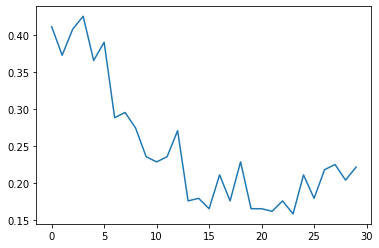

In [3]:
import numpy as np

acc_coef = np.load(r"./stratified_cross_validation_results/densenets/multinomial_acc_coef_360_-12_30.npy", allow_pickle=True)
raw_outputs = np.load(r"./stratified_cross_validation_results/densenets/multinomial_raw_outputs_360_-12_30.npy", allow_pickle=True)
print(len(acc_coef))


trainable_sequence = np.array([429, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412,
       411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399,
       398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
       372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
       359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
       346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
       333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321,
       320, 319, 318, 317, 316, 315, 314, 313, 311, 308, 307, 306, 305,
       304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292,
       291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279,
       278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266,
       265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253,
       252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240,
       239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227,
       226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214,
       213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201,
       200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
       187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175,
       174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162,
       161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149,
       148, 147, 146, 145, 144, 143, 142, 141, 139, 136, 135, 134, 133,
       132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120,
       119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  51,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   4,   3,   2])


from sklearn.metrics import confusion_matrix


def show_confusion_matrix(raw_outputs, fine_tune_layers):

    y_true = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1)
    y_pred = np.sum(
        np.rint(np.vstack(raw_outputs[fine_tune_layers, :, 2])), axis=1
    ).astype(int)
    return confusion_matrix(y_true, y_pred)

def show_matrix_percentage(confusion_matrix):
    return np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

# total accuracy
def calculate_accuracy(my_confusion_matrix):
    return np.trace(my_confusion_matrix)/np.sum(my_confusion_matrix)

max_acc_layer = np.argmax([calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])

my_confusion_matrix = show_confusion_matrix(raw_outputs,max_acc_layer)
print(my_confusion_matrix)
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(show_matrix_percentage(my_confusion_matrix))
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(calculate_accuracy(my_confusion_matrix)*100)

import matplotlib.pyplot as plt
plt.plot([i for i in range(len(acc_coef))],[calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(f"max accuracy with tuning from {trainable_sequence[360:0:-12][max_acc_layer]} layers, or tune {430 - trainable_sequence[360:0:-12][max_acc_layer]} layers")
print(max_acc_layer, [show_matrix_percentage(my_confusion_matrix)[i,i]*100 for i in range(5)])

In [17]:
for i in trainable_sequence[360:0:-12][9:]:
    print(i, end=", ")

170, 182, 194, 206, 218, 230, 242, 254, 266, 278, 290, 302, 317, 329, 341, 353, 365, 377, 389, 401, 413, 

In [30]:
# are we overffitng on the validation set?
# is validation set too small to measure performance accurately
# augment validation set?

In [28]:
test_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=56,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

full_model.evaluate(test_set)

Found 56 validated image filenames.
1/1 [==============================] - 1s 579ms/step - loss: 0.3455 - soft_acc_multi_output: 0.5357


[0.345540314912796, 0.53571427]

In [22]:
batch = next(test_set)
true_labels = batch[1]
predictions = full_model.predict(batch[0])
# np.corrcoef(predictions, true_labels)

In [26]:
np.sum(true_labels, axis=1)

array([1, 1, 4, 4, 3, 2, 0, 3, 4, 2, 4, 3, 1, 1, 4, 1, 3, 3, 0, 3, 4, 2,
       1, 1, 1, 1, 2, 3, 1, 2, 4, 0, 1, 0, 0, 2, 4, 2, 0, 1, 1, 4, 4, 0,
       1, 3, 3, 2, 0, 0, 1, 3, 1, 4, 0, 1])

In [27]:
np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))

array([[1.        , 0.81680143],
       [0.81680143, 1.        ]])

In [23]:
### city of overfit
########################################
# full_model.trainable = True
# for layer in full_model.layers[:-12]:
#     layer.trainable = False
# for layer in full_model.layers[-12:]:
#     layer.trainable = True

# validation_set.reset()
# train_set.reset()


# full_model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
# logdir_name = r".\tfb\logs\densenet_multinomial_logit\\" + full_model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
# early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
# reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.5)

# history_fine = full_model.fit_generator(generator=train_set,
#                     epochs=100+history_full_model.epoch[-1],
# #                     verbose=2,
#                     validation_data=validation_set,
#                     initial_epoch = history_full_model.epoch[-1],
#                     callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
#                     )

Epoch 25/124
16/16 [==============================] - 8s 506ms/step - loss: 0.5716 - soft_acc_multi_output: 0.2405 - val_loss: 0.7388 - val_soft_acc_multi_output: 0.1429
Epoch 26/124
16/16 [==============================] - 7s 451ms/step - loss: 0.4433 - soft_acc_multi_output: 0.3481 - val_loss: 1.3936 - val_soft_acc_multi_output: 0.1250
Epoch 27/124
16/16 [==============================] - 7s 458ms/step - loss: 0.4343 - soft_acc_multi_output: 0.3678 - val_loss: 1.7708 - val_soft_acc_multi_output: 0.1429
Epoch 28/124
16/16 [==============================] - 8s 470ms/step - loss: 0.3757 - soft_acc_multi_output: 0.4168 - val_loss: 1.7867 - val_soft_acc_multi_output: 0.1429
Epoch 29/124
16/16 [==============================] - 7s 455ms/step - loss: 0.3500 - soft_acc_multi_output: 0.4820 - val_loss: 2.6157 - val_soft_acc_multi_output: 0.1429
Epoch 30/124
16/16 [==============================] - 7s 460ms/step - loss: 0.3462 - soft_acc_multi_output: 0.4759 - val_loss: 3.0317 - val_soft_acc_m

In [ ]:
model.save(filepath="./saved_models/my_multinomial/1/", save_format="h5")

In [ ]:
model = tf.keras.models.load_model(
    filepath="./saved_models/my_effnet/1/",
    custom_objects={"soft_acc_multi_output": soft_acc_multi_output},
)

In [ ]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = full_model.predict(batch[0])
print(soft_acc_multi_output(y_true, y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]

    plt.imshow(img)
    plt.show()
    print(
        f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))}"
    )